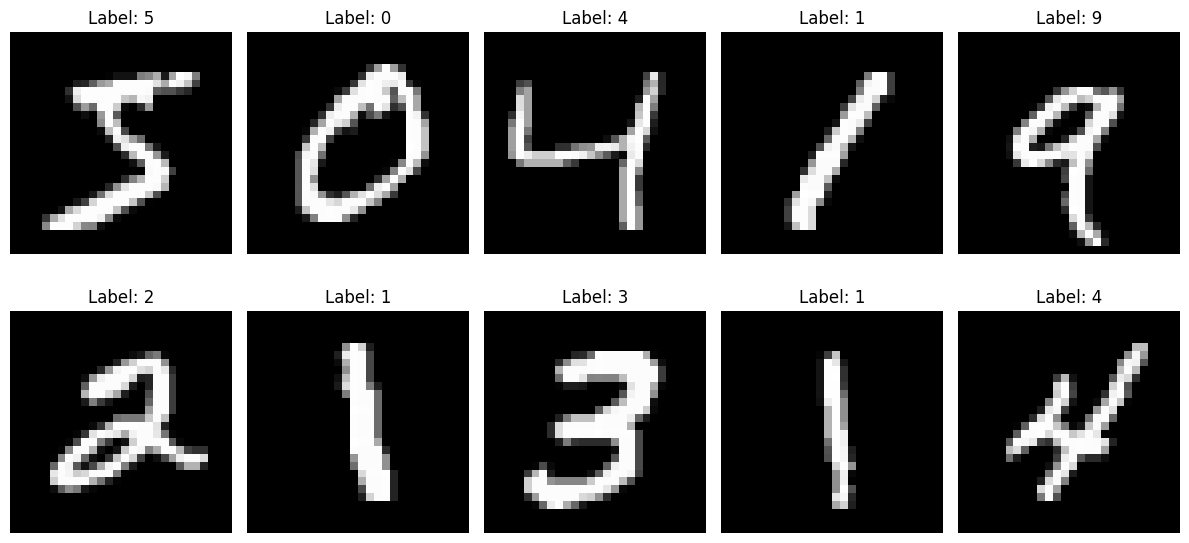

In [6]:

import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv

# Aufgabe 1: Laden des MNIST-Datensatzes
MNIST_dataset_train = tv.datasets.MNIST(root='./data', train=True, download=True)
MNIST_dataset_test = tv.datasets.MNIST(root='./data', train=False, download=True)

# Konvertieren des MNIST-Datensatzes in NumPy-Arrays
train_images = np.array([np.array(img) for img, _ in MNIST_dataset_train])
train_labels = np.array([label for _, label in MNIST_dataset_train])

test_images = np.array([np.array(img) for img, _ in MNIST_dataset_test])
test_labels = np.array([label for _, label in MNIST_dataset_test])

# Anzeigen der ersten 10 Bilder mit Matplotlib
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Aufgabe 2

In [134]:

class LinearLayer:
    """
    A simple Linear Layer.

    Parameters:
    -----------
    input_size: int
        The number of input features
    hidden_size: int
        The number of neurons in the hidden layer
    """
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Initialize weights and biases
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))

    def forward(self, X):
        """
        Perform forward propagation.
        
        Parameters:
        -----------
        X: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The predicted output
        """
        # Store input for backward pass
        self.X = X

        # Perform forward propagation
        self.z1 = np.dot(X, self.weights1) + self.bias1
        return self.z1

    def backward(self, dz):
        """
        Perform backpropagation for a single linear layer.
        
        Args:
          dz: numpy array
          Gradient of the cost with respect to the linear output of the layer.
          Returns:
          dx: numpy array
          Gradient of the cost with respect to the input of the layer.
          dw: numpy array
          Gradient of the cost with respect to the weights.
          db: numpy array
          Gradient of the cost with respect to the bias.
          """
        n = dz.shape[0]  # Number of samples in the batch
        
        # Gradient of the loss with respect to the weights
        self.dw1 = np.dot(self.X.T, dz) / n
        
        # Gradient of the loss with respect to the bias
        self.db1 = np.sum(dz, axis=0, keepdims=True) / n
        
        # Gradient of the loss with respect to the input of the layer
        self.dx1 = np.dot(dz, self.weights1.T)
        
        return self.dx1, self.dw1, self.db1

    def update(self, learning_rate):
        """
        Update weights and biases based on calculated gradients.
        
        Parameters:
        -----------
        learning_rate: float
        The learning rate for updating the weights and biases.
        """
        # Update weights
        self.weights1 -= learning_rate * self.dw1
        # Update biases
        self.bias1 -= learning_rate * self.db1
class Sigmoid:
    def forward(self, z):
        return 1 / (1 + np.exp(-z))

    def backward(self, z, dz):
        sig = self.forward(z)
        return dz * sig * (1 - sig)

# Testen der LinearLayer Klasse
class TestLinearLayer(unittest.TestCase):
    def setUp(self):
        # For reproducible results
        np.random.seed(42)
        # LinearLayer with predefined input and hidden size
        self.network = LinearLayer(input_size=2, hidden_size=1)
        # Set the weights and bias to known values
        self.network.weights1 = np.array([[0.1], [0.2]])
        self.network.bias1 = np.array([[0.3]])

    def test_forward(self):
        # Define a simple test case
        X = np.array([[0.5, -0.3]])
        # Perform forward propagation
        output = self.network.forward(X)
        # Check if output has the correct shape
        self.assertEqual(output.shape, (1, 1))

    def test_backward(self):
        # Input for backpropagation
        X = np.array([[0.5, -0.3]])
        # Perform forward propagation
        self.network.forward(X)
        # Assume random gradients for testing
        dz = np.random.randn(1, 1)
        # Perform backward propagation
        self.dx1, self.dw1, self.db1 = self.network.backward(dz)
        # Check if gradients have the correct shape
        self.assertEqual(self.dx1.shape, X.shape)
        self.assertEqual(self.dw1.shape, self.network.weights1.shape)
        self.assertEqual(self.db1.shape, self.network.bias1.shape)

    def test_update(self):
        # Input and target output for backpropagation
        X = np.array([[0.5, -0.3]])
        y = np.array([[1]])
        # Store the original weights
        original_weights = self.network.weights1.copy()
        original_bias = self.network.bias1.copy()
        # Perform forward and backward propagation
        self.network.forward(X)
        dz = np.random.randn(1, 1)  # Random gradients for testing
        self.dx1, self.dw1, self.db1 = self.network.backward(dz)
        # Update weights and biases
        learning_rate = 0.01
        self.network.update(learning_rate)
        # Check if weights and biases have been updated
        self.assertFalse(np.array_equal(self.network.weights1, original_weights))
        self.assertFalse(np.array_equal(self.network.bias1, original_bias))

# Execute the tests
unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


Aufgabe 3

C:\Users\rapha\AppData\Local\Temp\ipykernel_16896\1040664730.py:84: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy on test data: 0.8949416342412452


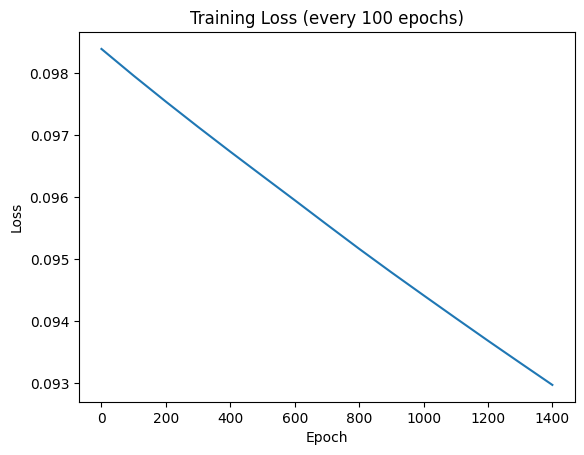

In [136]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the neural network with specified sizes for input, hidden, and output layers.

        Parameters:
        -----------
        input_size: int
            The number of input features
        hidden_size: int
            The number of neurons in the hidden layer
        output_size: int
            The number of neurons in the output layer
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_history = []
        # Initialize layers
        self.hidden_layer = LinearLayer(input_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)
        self.sigmoid = Sigmoid()

    def forward(self, X):
        """
        Perform forward propagation through the network.

        Parameters:
        -----------
        X: numpy array
            The input data

        Returns:
        --------
        numpy array
            The predicted output
        """
        # Forward pass through hidden layer
        self.hidden_output = self.sigmoid.forward(self.hidden_layer.forward(X))
        # Forward pass through output layer
        output = self.sigmoid.forward(self.output_layer.forward(self.hidden_output))
        return output

    def backward(self, X, y, learning_rate):
        """
        Perform backward propagation and update weights and biases.

        Parameters:
        -----------
        X: numpy array
            The input data
        y: numpy array
            The target output
        learning_rate: float
            The learning rate
        """
        # Compute loss derivative with respect to output
        loss_derivative = 2 * (self.output - y) / y.shape[0]  # Mean squared error loss derivative
        # Backpropagate through output layer
        dz_output = self.sigmoid.backward(self.output_layer.z1, loss_derivative)
        dx_output, dw_output, db_output = self.output_layer.backward(dz_output)
        # Backpropagate through hidden layer
        dz_hidden = self.sigmoid.backward(self.hidden_layer.z1, dx_output)
        dx_hidden, dw_hidden, db_hidden = self.hidden_layer.backward(dz_hidden)
        # Update weights and biases
        self.output_layer.update(learning_rate)
        self.hidden_layer.update(learning_rate)

    def train(self, X_train, y_train, epochs, learning_rate):
        """
        Train the neural network on the training data.

        Parameters:
        -----------
        X_train: numpy array
            The training input data
        y_train: numpy array
            The training target output
        epochs: int
            The number of training epochs
        learning_rate: float
            The learning rate
        """
        for epoch in range(epochs):
            # Forward pass
            self.output = self.forward(X_train)
            # Berechnung des Loss (MSE)
            loss = np.mean((self.output - y_train) ** 2)
            # Loss nur alle 100 Epochen speichern
            if epoch % 100 == 0:
                self.loss_history.append(loss)
            # Backward pass und Update der Gewichte
            self.backward(X_train, y_train, learning_rate)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the neural network on the test data.

        Parameters:
        -----------
        X_test: numpy array
            The test input data
        y_test: numpy array
            The test target output

        Returns:
        --------
        float
            The accuracy of the network on the test data
        """
        # Forward pass
        output = self.forward(X_test)
        # Convert output probabilities to binary predictions (0 or 1)
        predictions = np.where(output >= 0.5, 1, 0)
        # Calculate accuracy
        accuracy = np.mean(predictions == y_test)
        return accuracy

# Create and train the neural network
input_size = 28 * 28  # Size of MNIST images
hidden_size = 16  # Number of neurons in the hidden layer
output_size = 1  # Number of neurons in the output layer
learning_rate = 0.5
epochs = 1500

# Preprocess the data for binary classification (identify the digit 7)
train_images_7 = train_images[train_labels == 7]
train_labels_7 = np.ones((train_images_7.shape[0], 1))
test_images_7 = test_images[test_labels == 7]
test_labels_7 = np.ones((test_images_7.shape[0], 1))

# Train the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)
model.train(train_images_7.reshape(-1, input_size), train_labels_7, epochs, learning_rate)

# Evaluate the neural network
accuracy = model.evaluate(test_images_7.reshape(-1, input_size), test_labels_7)
print("Accuracy on test data:", accuracy)

# Plot loss history
plt.plot(range(0, epochs, 100), model.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (every 100 epochs)')
plt.show()


Aufgabe 4

C:\Users\rapha\AppData\Local\Temp\ipykernel_16896\1040664730.py:84: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Lernrate: 0.01
Größe des Hidden Layers: 4
Genauigkeit auf Testdaten: 0.41342412451361865
Genauigkeit auf Trainingsdaten: 0.4667198723064645

Lernrate: 0.01
Größe des Hidden Layers: 8
Genauigkeit auf Testdaten: 0.5749027237354085
Genauigkeit auf Trainingsdaten: 0.5594573024740622

Lernrate: 0.01
Größe des Hidden Layers: 16
Genauigkeit auf Testdaten: 0.7850194552529183
Genauigkeit auf Trainingsdaten: 0.7438148443735035

Lernrate: 0.1
Größe des Hidden Layers: 4
Genauigkeit auf Testdaten: 0.9630350194552529
Genauigkeit auf Trainingsdaten: 0.9675977653631285

Lernrate: 0.1
Größe des Hidden Layers: 8
Genauigkeit auf Testdaten: 0.5817120622568094
Genauigkeit auf Trainingsdaten: 0.5720670391061452

Lernrate: 0.1
Größe des Hidden Layers: 16
Genauigkeit auf Testdaten: 0.7626459143968871
Genauigkeit auf Trainingsdaten: 0.7567438148443735

Lernrate: 0.5
Größe des Hidden Layers: 4
Genauigkeit auf Testdaten: 0.9824902723735408
Genauigkeit auf Trainingsdaten: 0.9787709497206704

Lernrate: 0.5
Größe d

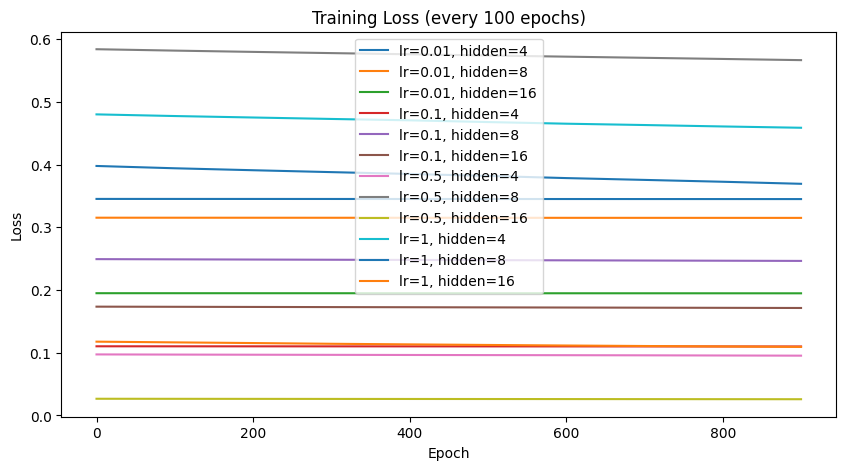

In [115]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_history = []
        self.hidden_layer = LinearLayer(input_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)
        self.sigmoid = Sigmoid()

    def forward(self, X):
        self.hidden_output = self.sigmoid.forward(self.hidden_layer.forward(X))
        output = self.sigmoid.forward(self.output_layer.forward(self.hidden_output))
        return output

    def backward(self, X, y, learning_rate):
        loss_derivative = 2 * (self.output - y) / y.shape[0]
        dz_output = self.sigmoid.backward(self.output_layer.z1, loss_derivative)
        dx_output, dw_output, db_output = self.output_layer.backward(dz_output)
        dz_hidden = self.sigmoid.backward(self.hidden_layer.z1, dx_output)
        dx_hidden, dw_hidden, db_hidden = self.hidden_layer.backward(dz_hidden)
        self.output_layer.update(learning_rate)
        self.hidden_layer.update(learning_rate)

    def train(self, X_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            self.output = self.forward(X_train)
            loss = np.mean((self.output - y_train) ** 2)
            if epoch % 100 == 0:
                self.loss_history.append(loss)
            self.backward(X_train, y_train, learning_rate)

    def evaluate(self, X_test, y_test):
        output = self.forward(X_test)
        predictions = np.where(output >= 0.5, 1, 0)
        accuracy = np.mean(predictions == y_test)
        return accuracy
# Aufgabe 1: Laden des MNIST-Datensatzes
MNIST_dataset_train = tv.datasets.MNIST(root='./data', train=True, download=True)
MNIST_dataset_test = tv.datasets.MNIST(root='./data', train=False, download=True)

# Konvertieren des MNIST-Datensatzes in NumPy-Arrays
train_images = np.array([np.array(img) for img, _ in MNIST_dataset_train])
train_labels = np.array([label for _, label in MNIST_dataset_train])

test_images = np.array([np.array(img) for img, _ in MNIST_dataset_test])
test_labels = np.array([label for _, label in MNIST_dataset_test])
# Daten vorbereiten
input_size = 28 * 28
output_size = 1
train_images_7 = train_images[train_labels == 7]
train_labels_7 = np.ones((train_images_7.shape[0], 1))
test_images_7 = test_images[test_labels == 7]
test_labels_7 = np.ones((test_images_7.shape[0], 1))

# Aufgabe 4: Trainieren mit verschiedenen Lernraten und Hidden Layer-Größen
learning_rates = [0.01, 0.1, 0.5, 1]
hidden_layer_sizes = [4, 8, 16]
epochs = 1000

results = []

for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        # Trainieren des neuronalen Netzwerks
        model = NeuralNetwork(input_size, hidden_size, output_size)
        model.train(train_images_7.reshape(-1, input_size), train_labels_7, epochs, lr)

        # Bewertung auf Testdaten
        accuracy_test = model.evaluate(test_images_7.reshape(-1, input_size), test_labels_7)

        # Bewertung auf Trainingsdaten
        accuracy_train = model.evaluate(train_images_7.reshape(-1, input_size), train_labels_7)

        results.append({
            'Lernrate': lr,
            'Größe des Hidden Layers': hidden_size,
            'Genauigkeit auf Testdaten': accuracy_test,
            'Genauigkeit auf Trainingsdaten': accuracy_train,
            'Verlauf des Verlusts': model.loss_history
        })

# Ergebnisse ausgeben
for result in results:
    print("Lernrate:", result['Lernrate'])
    print("Größe des Hidden Layers:", result['Größe des Hidden Layers'])
    print("Genauigkeit auf Testdaten:", result['Genauigkeit auf Testdaten'])
    print("Genauigkeit auf Trainingsdaten:", result['Genauigkeit auf Trainingsdaten'])
    print()

# Plot loss history
plt.figure(figsize=(10, 5))
for result in results:
    plt.plot(range(0, epochs, 100), result['Verlauf des Verlusts'], label=f"lr={result['Lernrate']}, hidden={result['Größe des Hidden Layers']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (every 100 epochs)')
plt.legend()
plt.show()

In [137]:

import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
import unittest

# Aufgabe 1: Laden des MNIST-Datensatzes
MNIST_dataset_train = tv.datasets.MNIST(root='./data', train=True, download=True)
MNIST_dataset_test = tv.datasets.MNIST(root='./data', train=False, download=True)

# Konvertieren des MNIST-Datensatzes in NumPy-Arrays
train_images = np.array([np.array(img) for img, _ in MNIST_dataset_train])
train_labels = np.array([label for _, label in MNIST_dataset_train])

test_images = np.array([np.array(img) for img, _ in MNIST_dataset_test])
test_labels = np.array([label for _, label in MNIST_dataset_test])

# Aufgabe 2: Implementierung der Klassen LinearLayer und Sigmoid (bereits vorhanden)

# Aufgabe 3: Erweiterung des NeuralNetworks
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_history = []
        # Initialize layers
        self.hidden_layer1 = LinearLayer(input_size, hidden_size)
        self.hidden_layer2 = LinearLayer(hidden_size, hidden_size)
        self.hidden_layer3 = LinearLayer(hidden_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)
        self.sigmoid = Sigmoid()

    def forward(self, X):
        # Forward pass through hidden layers
        hidden_output1 = self.sigmoid.forward(self.hidden_layer1.forward(X))
        hidden_output2 = self.sigmoid.forward(self.hidden_layer2.forward(hidden_output1))
        hidden_output3 = self.sigmoid.forward(self.hidden_layer3.forward(hidden_output2))
        # Forward pass through output layer
        output = self.sigmoid.forward(self.output_layer.forward(hidden_output3))
        return output

    def backward(self, X, y, learning_rate):
        # Compute loss derivative with respect to output
        loss_derivative = 2 * (self.output - y) / y.shape[0]
        # Backpropagate through output layer
        dz_output = self.sigmoid.backward(self.output_layer.z1, loss_derivative)
        dx_output, dw_output, db_output = self.output_layer.backward(dz_output)
        # Backpropagate through hidden layers
        dz_hidden3 = self.sigmoid.backward(self.hidden_layer3.z1, dx_output)
        dx_hidden3, dw_hidden3, db_hidden3 = self.hidden_layer3.backward(dz_hidden3)
        dz_hidden2 = self.sigmoid.backward(self.hidden_layer2.z1, dx_hidden3)
        dx_hidden2, dw_hidden2, db_hidden2 = self.hidden_layer2.backward(dz_hidden2)
        dz_hidden1 = self.sigmoid.backward(self.hidden_layer1.z1, dx_hidden2)
        dx_hidden1, dw_hidden1, db_hidden1 = self.hidden_layer1.backward(dz_hidden1)
        # Update weights and biases
        self.output_layer.update(learning_rate)
        self.hidden_layer3.update(learning_rate)
        self.hidden_layer2.update(learning_rate)
        self.hidden_layer1.update(learning_rate)

    def train(self, X_train, y_train, epochs, learning_rate, batch_size):
        for epoch in range(epochs):
            # Shuffle training data for stochasticity
            indices = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            # Split data into mini-batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                # Forward pass
                self.output = self.forward(X_batch)
                # Compute loss (MSE)
                loss = np.mean((self.output - y_batch) ** 2)
                self.loss_history.append(loss)
                # Backward pass and weight update
                self.backward(X_batch, y_batch, learning_rate)

    def evaluate(self, X_test, y_test):
        output = self.forward(X_test)
        predictions = np.argmax(output, axis=1)
        accuracy = np.mean(predictions == y_test)
        return accuracy

# Aufgabe 4: Trainieren mit verschiedenen Lernraten und Hidden Layer-Größen
input_size = 28 * 28
output_size = 10
hidden_layer_sizes = [4, 8, 16]
learning_rates = [0.01, 0.1, 0.5, 1]
epochs = 1000
batch_size = 64

results = []

for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        # Preprocess the data for multi-class classification
        train_labels_multi = np.eye(10)[train_labels]  # One-hot encoding
        test_labels_multi = np.eye(10)[test_labels]

        # Train the neural network
        model = NeuralNetwork(input_size, hidden_size, output_size)
        model.train(train_images.reshape(-1, input_size), train_labels_multi, epochs, lr, batch_size)

        # Evaluate the neural network
        accuracy_test = model.evaluate(test_images.reshape(-1, input_size), test_labels)
        accuracy_train = model.evaluate(train_images.reshape(-1, input_size), train_labels)

        results.append({
            'Learning Rate': lr,
            'Hidden Layer Size': hidden_size,
            'Accuracy on Test Data': accuracy_test,
            'Accuracy on Train Data': accuracy_train,
            'Loss History': model.loss_history
        })

# Print results
for result in results:
    print("Learning Rate:", result['Learning Rate'])
    print("Hidden Layer Size:", result['Hidden Layer Size'])
    print("Accuracy on Test Data:", result['Accuracy on Test Data'])
    print("Accuracy on Train Data:", result['Accuracy on Train Data'])
    print()

# Plot loss history
plt.figure(figsize=(10, 5))
for result in results:
    plt.plot(range(len(result['Loss History'])), result['Loss History'], label=f"lr={result['Learning Rate']}, hidden={result['Hidden Layer Size']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


C:\Users\rapha\AppData\Local\Temp\ipykernel_16896\1040664730.py:84: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
